# Predict the Success of Bank telemarketing

### 1. Importing Libraries

In [25]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, classification_report
import warnings
warnings.filterwarnings('ignore')

In [26]:
train_data = pd.read_csv('/kaggle/input/predict-the-success-of-bank-telemarketing/train.csv')
test_data = pd.read_csv('/kaggle/input/predict-the-success-of-bank-telemarketing/test.csv')
sample_submission = pd.read_csv('/kaggle/input/predict-the-success-of-bank-telemarketing/sample_submission.csv')

In [27]:
print("Train data - ")
train_data.head()

Train data - 


,last contact date,age,job,marital,education,default,balance,housing,loan,contact,duration,campaign,pdays,previous,poutcome,target
0,2009-04-17,26,blue-collar,married,secondary,no,647,yes,no,cellular,357,2,331,1,other,no
1,2009-10-11,52,technician,married,secondary,no,553,yes,no,telephone,160,1,-1,0,NaN,no
2,2010-11-20,44,blue-collar,married,secondary,no,1397,no,no,cellular,326,1,-1,0,NaN,no
3,2009-09-01,33,admin.,married,secondary,no,394,yes,no,telephone,104,3,-1,0,NaN,no
4,2008-01-29,31,entrepreneur,single,tertiary,no,137,no,no,cellular,445,2,-1,0,NaN,no


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

### 2. Exploratory Data Analysis (EDA)

In [29]:
train_data.isnull().sum()

train_data.shape

(39211, 16)

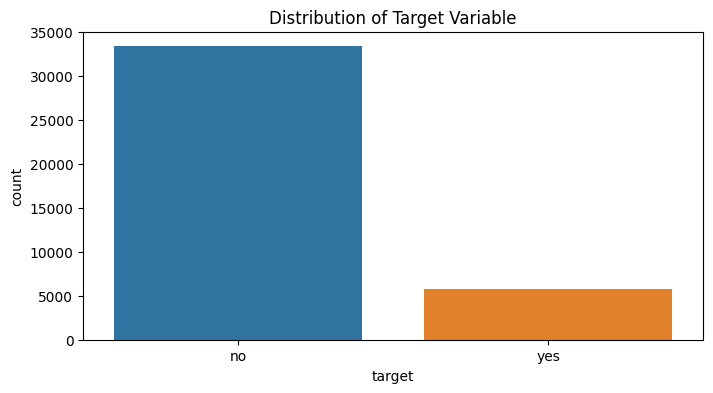

In [30]:
plt.figure(figsize=(8, 4))
sns.countplot(x='target', data=train_data)
plt.title('Distribution of Target Variable')
plt.show()

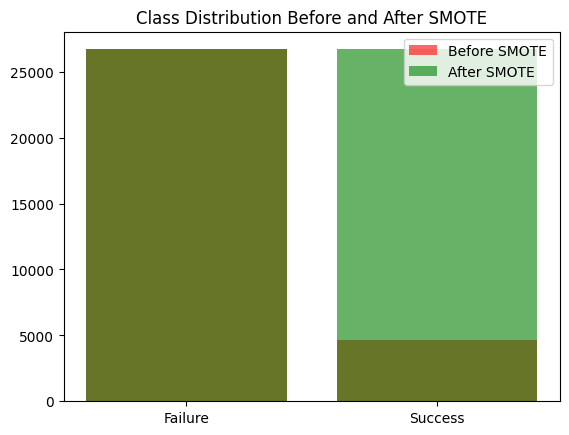

In [31]:
from collections import Counter
before = Counter(y_train)
X_sm, y_sm = SMOTE(random_state=42).fit_resample(X_train, y_train)
after = Counter(y_sm)

plt.bar(before.keys(), before.values(), label='Before SMOTE', color='red', alpha=0.6)
plt.bar(after.keys(), after.values(), label='After SMOTE', color='green', alpha=0.6)
plt.xticks([0, 1], ['Failure', 'Success'])
plt.legend()
plt.title('Class Distribution Before and After SMOTE')
plt.show()

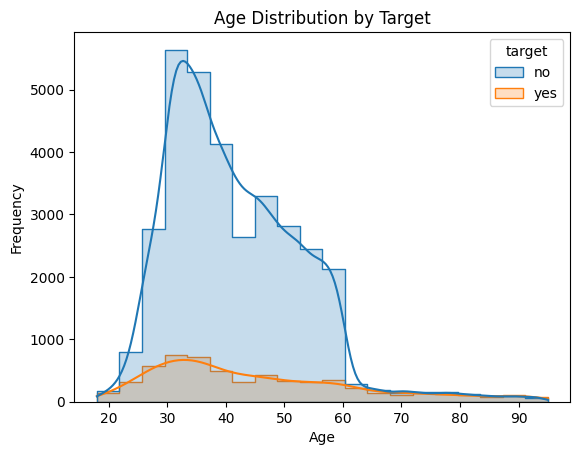

In [32]:
sns.histplot(data=train_data, x='age', hue='target', kde=True, element='step', bins=20)
plt.title('Age Distribution by Target')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# for feature in numerical_features:
#     plt.figure(figsize=(6, 4))
#     sns.boxplot(data=train_data, y=feature, color='orange')
#     plt.title(f"Boxplot of {feature}")
#     plt.ylabel(feature)
#     plt.show()

### 3. Data Preprocessing

In [35]:
train_data['poutcome'].fillna('unknown', inplace=True)
test_data['poutcome'].fillna('unknown', inplace=True)
train_data['contact'].fillna('unknown', inplace=True)
test_data['contact'].fillna('unknown', inplace=True)
train_data.fillna(-1, inplace=True)
test_data.fillna(-1, inplace=True)

categorical_features = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'poutcome']
for feature in categorical_features:
    train_data[feature] = train_data[feature].astype(str)  # Convert to string
    test_data[feature] = test_data[feature].astype(str)    # Convert to string

le = LabelEncoder()
for feature in categorical_features:
    train_data[feature] = le.fit_transform(train_data[feature])
    test_data[feature] = le.transform(test_data[feature])

train_data['last_contact_date'] = pd.to_datetime(train_data['last contact date'])
test_data['last_contact_date'] = pd.to_datetime(test_data['last contact date'])

train_data['contact_year'] = train_data['last_contact_date'].dt.year
train_data['contact_month'] = train_data['last_contact_date'].dt.month
train_data['contact_day'] = train_data['last_contact_date'].dt.day

test_data['contact_year'] = test_data['last_contact_date'].dt.year
test_data['contact_month'] = test_data['last_contact_date'].dt.month
test_data['contact_day'] = test_data['last_contact_date'].dt.day

train_data.drop(columns=['last contact date', 'last_contact_date'], inplace=True)
test_data.drop(columns=['last contact date', 'last_contact_date'], inplace=True)


In [36]:
X = train_data.drop(columns=['target'])
y = train_data['target'].apply(lambda x: 1 if x == 'yes' else 0)
X_test = test_data.copy()

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

numerical_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
numerical_features.remove('age') 

preprocessor = ColumnTransformer(
    transformers=[('num', StandardScaler(), numerical_features)],
    remainder='passthrough'  
)

smote = SMOTE(random_state=42)

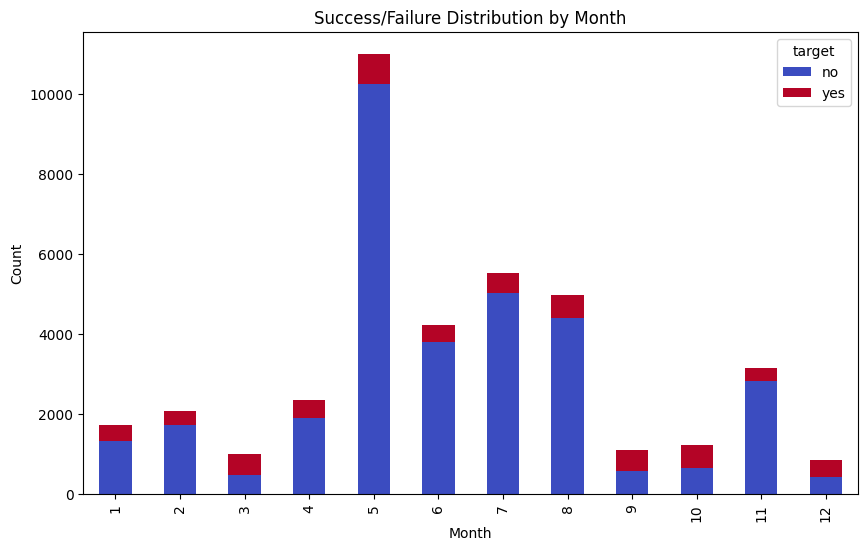

In [45]:
time_analysis = train_data.groupby(['contact_month', 'target'])['target'].count().unstack()
time_analysis.plot(kind='bar', figsize=(10, 6), stacked=True, colormap='coolwarm')
plt.title('Success/Failure Distribution by Month')
plt.ylabel('Count')
plt.xlabel('Month')
plt.show()

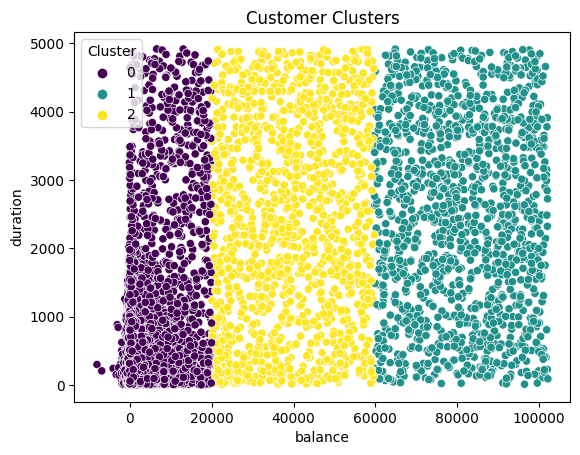

In [46]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(train_data[numerical_features])

train_data['Cluster'] = clusters
sns.scatterplot(data=train_data, x='balance', y='duration', hue='Cluster', palette='viridis')
plt.title('Customer Clusters')
plt.show()

In [ ]:
# if 'contact' in test_data.columns:
#     test_data['contact'].fillna('unknown', inplace=True)

# categorical_columns = ['job', 'marital', 'education', 'contact', 'poutcome']

# test_data_encoded = pd.get_dummies(test_data, columns=[col for col in categorical_columns if col in test_data.columns], drop_first=True)

# test_data_encoded = test_data_encoded.reindex(columns=X_train.columns, fill_value=0)

# test_preds = rf.predict(test_data_encoded)

# submission = pd.DataFrame({
#     'id': test_data.index,  
#     'target': test_preds  
# })

# submission.to_csv('submission.csv', index=False)

# submission.head()

### 4. Model Building

Initializing Parameter Grid for Hyperparameter Tuning (HPT) and Model Pipeline

In [37]:
rf_model = RandomForestClassifier(random_state=42)

param_grid_rf = {
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [3, 5, 7],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4],
    'model__bootstrap': [True, False]
}

rf_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', smote), 
    ('model', rf_model)  
])

In [38]:
lgbm_model = LGBMClassifier(random_state=42)

# Define Hyperparameter Grid for LightGBM
param_grid_lgbm = {
    'model__learning_rate': [0.01, 0.05, 0.1],
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [3, 5, 7],
    'model__num_leaves': [31, 63, 127],  
    'model__subsample': [0.8, 0.9, 1.0],
    'model__colsample_bytree': [0.6, 0.8, 1.0],
    'model__reg_alpha': [0, 0.1, 0.2],
    'model__reg_lambda': [0.1, 0.2, 0.3]
}

lgbm_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),  
    ('smote', smote), 
    ('model', lgbm_model)  
])

In [39]:
random_search_rf = RandomizedSearchCV(
    estimator=rf_pipeline,
    param_distributions=param_grid_rf,
    n_iter=10, 
    scoring='f1_macro',
    cv=3,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

random_search_lgbm = RandomizedSearchCV(
    estimator=lgbm_pipeline,
    param_distributions=param_grid_lgbm,
    n_iter=10,  
    scoring='f1_macro',
    cv=3,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

In [40]:
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

scaler = StandardScaler()
X_train_sm_scaled = scaler.fit_transform(X_train_sm)
X_val_scaled = scaler.transform(X_val)

lr = LogisticRegression(random_state=42, max_iter=1000)
lr.fit(X_train_sm_scaled, y_train_sm)

y_val_pred_lr = lr.predict(X_val_scaled)

f1_lr = f1_score(y_val, y_val_pred_lr, average='macro')
print(f"Logistic Regression F1 Score (Macro): {f1_lr:.4f}")

Logistic Regression F1 Score (Macro): 0.6391


In [41]:
print("Tuning RandomForest model...")
random_search_rf.fit(X_train, y_train)

print("Tuning LightGBM model...")
random_search_lgbm.fit(X_train, y_train)

warnings.filterwarnings('ignore')

print(f"Best parameters for RandomForest: {random_search_rf.best_params_}")
best_rf = random_search_rf.best_estimator_

print(f"Best parameters for LightGBM: {random_search_lgbm.best_params_}")
best_lgbm = random_search_lgbm.best_estimator_

y_val_pred_rf = best_rf.predict(X_val)
f1_rf = f1_score(y_val, y_val_pred_rf, average='macro')
print(f'F1 Score (Macro) on validation set for Random Forest: {f1_rf:.4f}')
print(classification_report(y_val, y_val_pred_rf))

y_val_pred_lgbm = best_lgbm.predict(X_val)
f1_lgbm = f1_score(y_val, y_val_pred_lgbm, average='macro')
print(f'F1 Score (Macro) on validation set for LightGBM: {f1_lgbm:.4f}')
print(classification_report(y_val, y_val_pred_lgbm))

Tuning RandomForest model...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Tuning LightGBM model...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
[LightGBM] [Info] Number of positive: 17804, number of negative: 17804
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015611 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4335
[LightGBM] [Info] Number of data points in the train set: 35608, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] 

### 5. Model Evaluation

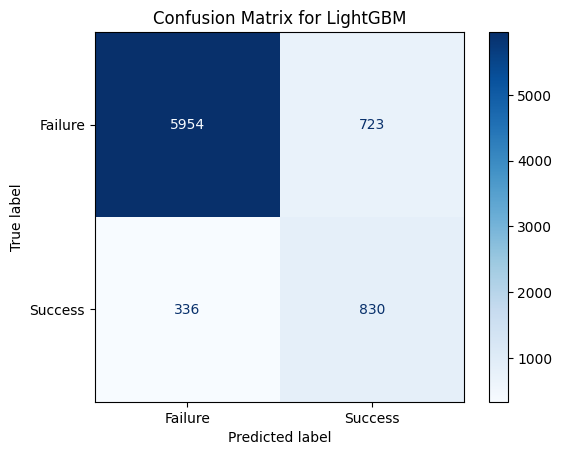

In [42]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(best_lgbm, X_val, y_val, display_labels=['Failure', 'Success'], cmap='Blues')
plt.title("Confusion Matrix for LightGBM")
plt.show()

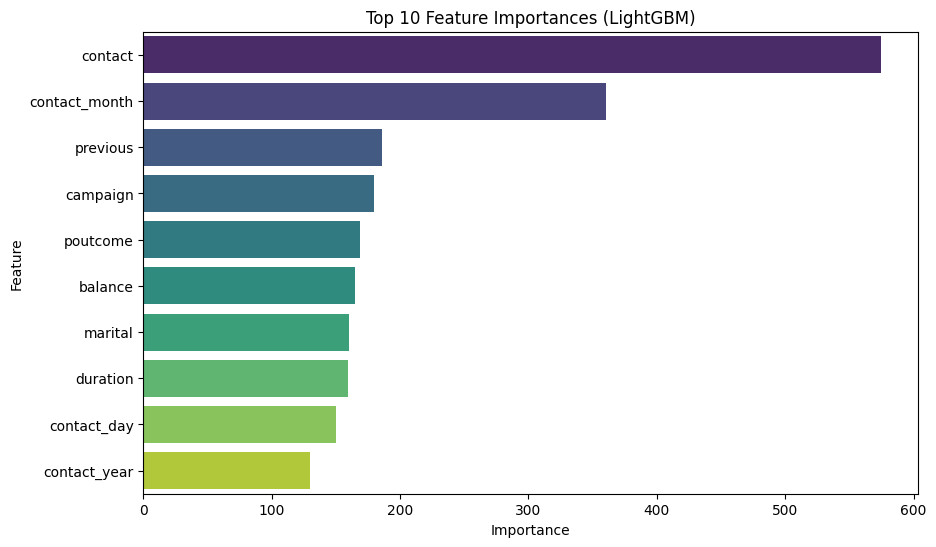

In [43]:
importances = best_lgbm.named_steps['model'].feature_importances_
feature_names = X_train.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(10), palette='viridis')
plt.title('Top 10 Feature Importances (LightGBM)')
plt.show()

### 6. Best Model Selection and submission

In [44]:
best_model = None
best_f1 = max(f1_rf, f1_lgbm)

if best_f1 == f1_rf:
    print("Using Random Forest for final predictions")
    best_model = best_rf
else:
    print("Using LightGBM for final predictions")
    best_model = best_lgbm

y_test_pred_best = best_model.predict(X_test)

submission = pd.DataFrame({
    'id': test_data.index,
    'target': np.where(y_test_pred_best == 1, 'yes', 'no')
})

submission.to_csv('submission.csv', index=False)
print("Submission file saved as 'submission.csv'.")

Using LightGBM for final predictions
Submission file saved as 'submission.csv'.
